In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings("ignore")

# Lee el archivo CSV
df = pd.read_csv('student.csv')

#Con esta funcion seleccionamos los atributos categoricos y los transformamos a codificacion onehoot
categorical_columns = df.select_dtypes(include=['object']).columns
for i in categorical_columns:
    if len(df[i].unique()) == 2:
        # Si solo hay dos categorías, usar LabelEncoder
        le = LabelEncoder()
        df[i] = le.fit_transform(df[i])
    else:
        df_dummies = pd.get_dummies(df[i], prefix=i)
        df = pd.concat([df.drop(i, axis=1), df_dummies], axis=1)
    
#comprobamos que ahora todos son atributos numericos (int64)
print(df.info())
print(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   school             649 non-null    int64
 1   sex                649 non-null    int64
 2   age                649 non-null    int64
 3   address            649 non-null    int64
 4   famsize            649 non-null    int64
 5   Pstatus            649 non-null    int64
 6   Medu               649 non-null    int64
 7   Fedu               649 non-null    int64
 8   traveltime         649 non-null    int64
 9   studytime          649 non-null    int64
 10  schoolsup          649 non-null    int64
 11  famsup             649 non-null    int64
 12  paid               649 non-null    int64
 13  activities         649 non-null    int64
 14  nursery            649 non-null    int64
 15  higher             649 non-null    int64
 16  internet           649 non-null    int64
 17  romantic        

In [23]:
#Hacemos un particionamiento estandar, 70% para train y 30% para test
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)

#Sacamos los atributos target
y_train_semana = train_data['Dalc']
y_train_finde = train_data['Walc']

#definimos X con el resto de atributos de entrenamiento
X_train = train_data.drop(['Dalc', 'Walc'], axis=1)

#Sacamos los atributos target
y_test_semana = test_data['Dalc']
y_test_finde = test_data['Walc']

#definimos X con el resto de atributos de entrenamiento
X_test = test_data.drop(['Dalc', 'Walc'], axis=1)

In [24]:
X_train

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,...,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
579,1,1,18,1,1,1,1,3,1,1,...,0,1,0,1,0,0,0,0,1,0
211,0,1,16,0,1,1,3,3,3,1,...,1,0,0,0,1,0,0,1,0,0
9,0,1,15,1,0,1,3,4,1,2,...,1,0,0,0,1,0,0,0,1,0
612,1,1,17,0,0,1,4,3,2,2,...,1,0,0,0,1,0,0,0,1,0
299,0,0,20,0,0,1,2,1,2,2,...,1,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0,1,15,1,0,1,4,2,1,4,...,1,0,0,1,0,0,0,0,1,0
106,0,0,15,1,0,1,2,2,1,4,...,1,0,0,1,0,0,0,0,1,0
270,0,1,16,1,0,1,4,4,1,1,...,0,1,0,1,0,0,0,0,1,0
435,1,0,15,0,1,1,1,1,2,2,...,0,1,0,0,0,0,1,1,0,0


# REGRESION LOGISTICA MULTICLASE

Este paso inicial nos permite establecer un punto de partida para nuestro proyecto. Al empezar con un modelo sencillo, podemos determinar rápidamente si nuestro problema puede resolverse fácilmente y qué características son las más relevantes. Además, nos permite familiarizarnos con el proceso de preparación de datos, entrenamiento de modelos y evaluación de resultados sin la complejidad que podrían añadir los modelos más avanzados.

Un modelo de clasificación básico, como la regresión logística es una excelente elección para empezar. Estos modelos son relativamente fáciles de comprender e implementar, y proporcionan una buena intuición sobre cómo funcionan los algoritmos. Aunque estos modelos pueden no ser los más precisos para tareas complejas, a menudo pueden proporcionar resultados bastante buenos en muchos problemas.

Después de entrenar y evaluar nuestro modelo de clasificación básico, podremos utilizar estos resultados como referencia para los modelos más complejos que podríamos explorar en el futuro. Al comparar los resultados de diferentes modelos, podremos ver claramente cómo las mejoras en la complejidad del modelo pueden llevar a mejoras en el rendimiento. Esto nos ayudará a tomar decisiones informadas sobre qué dirección tomar en nuestras futuras exploraciones del modelo.

In [25]:
#Enfoque OvA, one vs all, calculamos la probabilidad que tiene que ejemplo de pertenecer a una clase y nos quedamos con la mejor
modelo_logistico = LogisticRegression(multi_class='ovr', solver='liblinear')


#En lugar de utilizar clasificadores binarios utiliza un solo clasificador que tiene en cuenta la relacion entre todas las clases calculando la probabilidad conjunta
modelo_logistico = LogisticRegression(multi_class='multinomial', solver='lbfgs')

#Entrenamos el modelo
modelo_logistico.fit(X_train, y_train_semana)

#Calculamos la salida del modelo
y_pred = modelo_logistico.predict(X_test)
precision = accuracy_score(y_test_semana, y_pred)
print("Precision semana = ", precision)


#Realizamos el mismo proceso para los datos del fin de semana
modelo_logistico.fit(X_train, y_train_finde)
y_pred = modelo_logistico.predict(X_test)
precision = accuracy_score(y_test_finde, y_pred)
print("Precision finde = ", precision)

Precision semana =  0.6820512820512821
Precision finde =  0.35384615384615387


# NAIVE BAYES

In [26]:
naive_bayes_classifier = GaussianNB()

# Entrenar el modelo con el conjunto de entrenamiento
naive_bayes_classifier.fit(X_train, y_train_semana)

# Realizar predicciones en el conjunto de prueba
y_pred = naive_bayes_classifier.predict(X_test)

# Evaluar el rendimiento del modelo
accuracy = 100 * metrics.accuracy_score(y_test_semana, y_pred)
print(f'Precisión del modelo: {accuracy}')

# Imprimir la matriz de confusión para evaluar el rendimiento en detalle


Precisión del modelo: 5.641025641025641


# ENSEMBLES ADABOOST

Tras aplicar AdaBoost, vemos que la precision de nuestro modelo varía en función del numero de clasificadores base que utilicemos. Podemos comprobar, que en nuestro caso, cuantos mas clasificadores añadimos peor precision obtenemos.

In [32]:
numero_clasificadores_base = 1

mejor_num_clasificadores_semana = 0
mejor_num_clasificadores_finde = 0

mejor_acc_semana = 0
mejor_acc_finde = 0

lista_precision_semana = []
lista_precision_finde = []


for i in range(1, 100):
    #Defininos el clasificadores base
    clasificador_base = DecisionTreeClassifier(criterion='entropy', max_depth=1)
    
    #Definimos el modelo y entrenamos
    adaboost_semana = AdaBoostClassifier(base_estimator=clasificador_base, n_estimators=numero_clasificadores_base, random_state=12)
    adaboost_semana.fit(X_train, y_train_semana)
    
    adaboost_finde = AdaBoostClassifier(base_estimator=clasificador_base, n_estimators=numero_clasificadores_base, random_state=12)
    adaboost_finde.fit(X_train, y_train_finde)
    
    #Calculamos la precision
    acc_semana = round(100*adaboost_semana.score(X_test, y_test_semana), 2)
    acc_finde = round(100*adaboost_finde.score(X_test, y_test_finde), 2)
    
    #Añadimos las precisiones a su correspondiente lista para dibujarlas en las graficas
    lista_precision_semana.append(acc_semana)
    lista_precision_finde.append(acc_finde)
    
    #Comprobamos cual es el mejor numero de clasificadores para obtener la mayor precision
    if (acc_semana >= mejor_acc_semana):
        mejor_acc_semana = acc_semana
        mejor_num_clasificadores_semana = numero_clasificadores_base
    if (acc_finde >= mejor_acc_finde):
        mejor_acc_finde = acc_finde
        mejor_num_clasificadores_finde = numero_clasificadores_base
        
    numero_clasificadores_base += 1
    
print("El mejor numero de clasificadores es: " + str(mejor_num_clasificadores_semana) + ", con una precision del: " + str(mejor_acc_semana))
print("El mejor numero de clasificadores es: " + str(mejor_num_clasificadores_finde) + ", con una precision del: " + str(mejor_acc_finde))

El mejor numero de clasificadores es: 3, con una precision del: 68.21
El mejor numero de clasificadores es: 6, con una precision del: 41.54


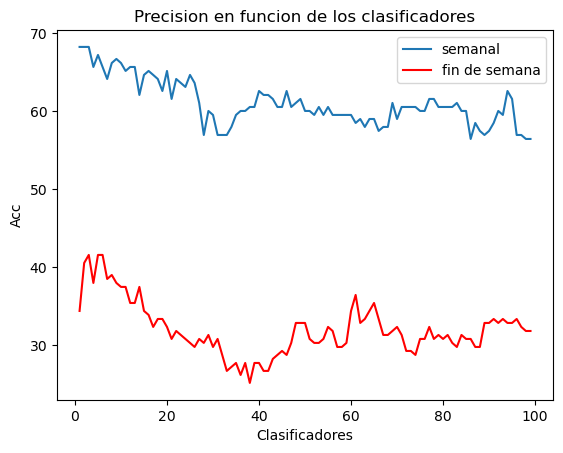

In [28]:
clasificadores = np.arange(1, numero_clasificadores_base)

plt.plot(clasificadores, lista_precision_semana, label = "semanal")
plt.plot(clasificadores, lista_precision_finde, label='fin de semana', color='red')
plt.title('Precision en funcion de los clasificadores')
plt.xlabel('Clasificadores')
plt.ylabel('Acc')
plt.legend()

# Ensemble Bagging

In [29]:
# Importa la clase necesaria para usar Bagging
from sklearn.ensemble import BaggingClassifier

# Se define el número de clasificadores base de AdaBoost. Utiliza 5 clasificadores base.
numero_clasificadores_base = 5
# Llamada al constructor del clasificador AdaBoost
clasificador_base = DecisionTreeClassifier(criterion='entropy', max_depth=1)

bagging = BaggingClassifier(clasificador_base, n_estimators=numero_clasificadores_base, random_state=12)

# Entrenamiento del clasificador creado
bagging.fit(X_train, y_train_semana)


acc = round(100 * bagging.score(X_test, y_test_semana), 2)
print(acc)

68.21


# OVA

In [30]:
# Se importan las clase para OVA y para SVM
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

# Se llama al constructor de OVA utilizando SVM como clasificador base
# <RELLENAR>
OVA = OneVsRestClassifier(estimator=SVC())

# Se entrena el modelo OVA
OVA.fit(X_train, y_train_semana)
acc = round(100 * OVA.score(X_test, y_test_semana), 2)
print(acc)

68.72


# RED NEURONAL

0.717948717948718
31
8


Text(0, 0.5, 'Accuracy')

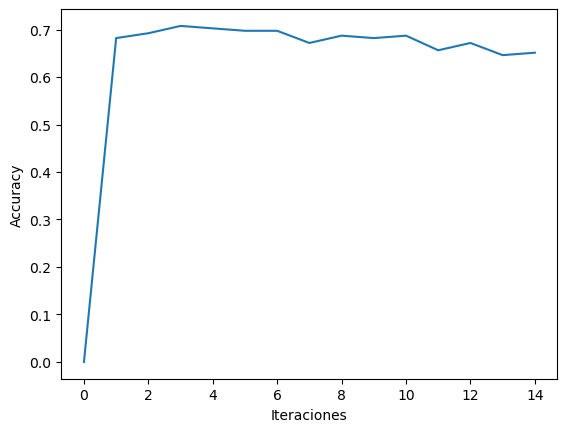

In [31]:
from sklearn.neural_network import MLPClassifier


max_acc = 0
max_hidden_layer = 0
max_iteration = 0

accuracies = np.zeros(15)


for i in range(1, 15):
    for j in range(1, 100):
        clasificador = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(i,), max_iter=j)
        clasificador.fit(X_train, y_train_semana)

        y_pred = clasificador.predict(X_test)

        accuracy = metrics.accuracy_score(y_test_semana, y_pred)
        
        if (accuracy >= max_acc):
            max_hidden_layer = i
            max_acc = accuracy
            max_iteration = j
            
    accuracies[i] = accuracy
    
        
print(max_acc)
print(max_iteration)
print(max_hidden_layer)


fig, ax = plt.subplots()
ax.plot(accuracies)
ax.set_xlabel("Iteraciones")
ax.set_ylabel("Accuracy")